In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from vit_pytorch import ViT

cudnn.becnmark = True
plt.ion()

### Load the Data

In [9]:
# Add transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


# Load the dataset
train_dir = '/home/admin1/CSD/ALaM/Jom/Vision_Transformer/Tower_Dataset_Clean/train'
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])

val_dir = '/home/admin1/CSD/ALaM/Jom/Vision_Transformer/Tower_Dataset_Clean/val'
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}

# Dataset sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [7]:
for labels, images in dataloaders['train']:
    print(images)
    break
images.shape

tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1])


torch.Size([32])

## Visualize some images

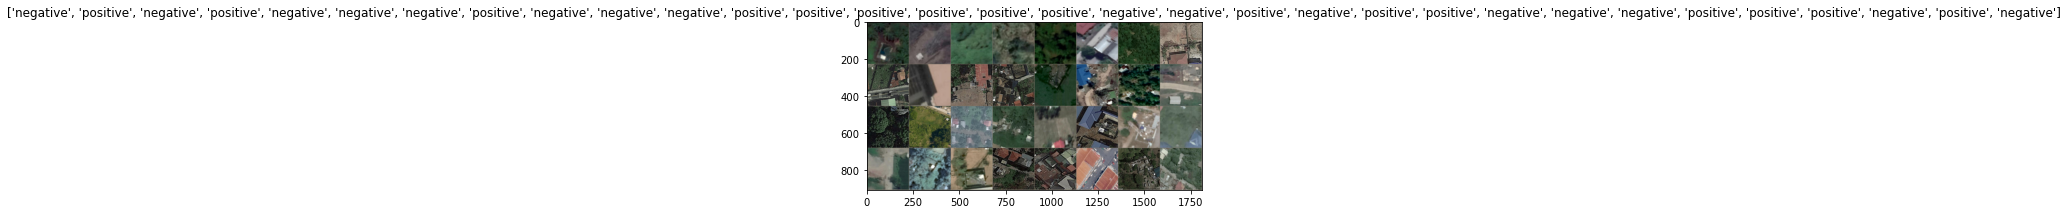

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training function

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.float()
                    #_, preds = torch.max(outputs, 1)
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                #running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

## Train the model

In [5]:
class VanillaViT(nn.Module):
    def __init__(self,image_size = 224, patch_size = 16, num_classes = 1, dim = 1024, depth = 16, heads = 16,
                mlp_dim = 2048, dropout = 0.1, emb_dropout = 0.1 ):
        super(VanillaViT, self).__init__()
        self.model = ViT(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, 
                         heads=heads, mlp_dim=mlp_dim, dropout=dropout, emb_dropout=emb_dropout)
       
    def forward(self, x):
        output = self.model(x)
        
        return output


EuroSAT = torch.load('20220716-163640.pth')




In [8]:
for param in EuroSAT.parameters():
    param.requires_grad = False

model = nn.Sequential(
    EuroSAT,
    nn.Linear(10, 1)
    )

model = model.to(device)


criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0 / 49
----------


/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [7,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [8,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [9,0,0] Assertio

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.